In [1]:
!pip3 install -q optuna seaborn umap-learn

In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    root_mean_squared_error, 
    confusion_matrix,
    ConfusionMatrixDisplay, 
    mean_squared_error,
    f1_score,
    roc_auc_score
)
import umap.umap_ as umap
import joblib

In [3]:
# import sprf package
from notebooks.sprf import SpatialRandomForest
from notebooks.sprf.geographical_random_forest import GeographicalRandomForest

### Read contents of AEGISDataset

In [4]:
# Read the CSV file into a DataFrame
df = pd.read_csv('../aegis_flood_data/AEGISDataset_SJOIN_merged_cleaned.csv')
df = df.drop(columns=['Unnamed: 0', 'geometry', 'flood_height'], errors='ignore')

In [5]:
# Display the first few rows of the DataFrame
print("Data Head:")
df.head()

Data Head:


,lat,lon,elevation,precipitation,is_flooding,hazard_level
0,14.640394,121.055708,54.553295,9.0,0,0.0
1,14.698299,121.002132,21.856272,10.0,0,0.0
2,14.698858,121.100261,69.322807,16.0,0,0.0
3,14.571310,120.983334,10.987241,8.0,0,0.0
4,14.762232,121.075735,87.889847,18.0,0,0.0


In [6]:
# Display information on about the DataFrame
print("\nData Info:")
print(df.info())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lat            3511 non-null   float64
 1   lon            3511 non-null   float64
 2   elevation      3511 non-null   float64
 3   precipitation  3511 non-null   float64
 4   is_flooding    3511 non-null   int64  
 5   hazard_level   3511 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 164.7 KB
None


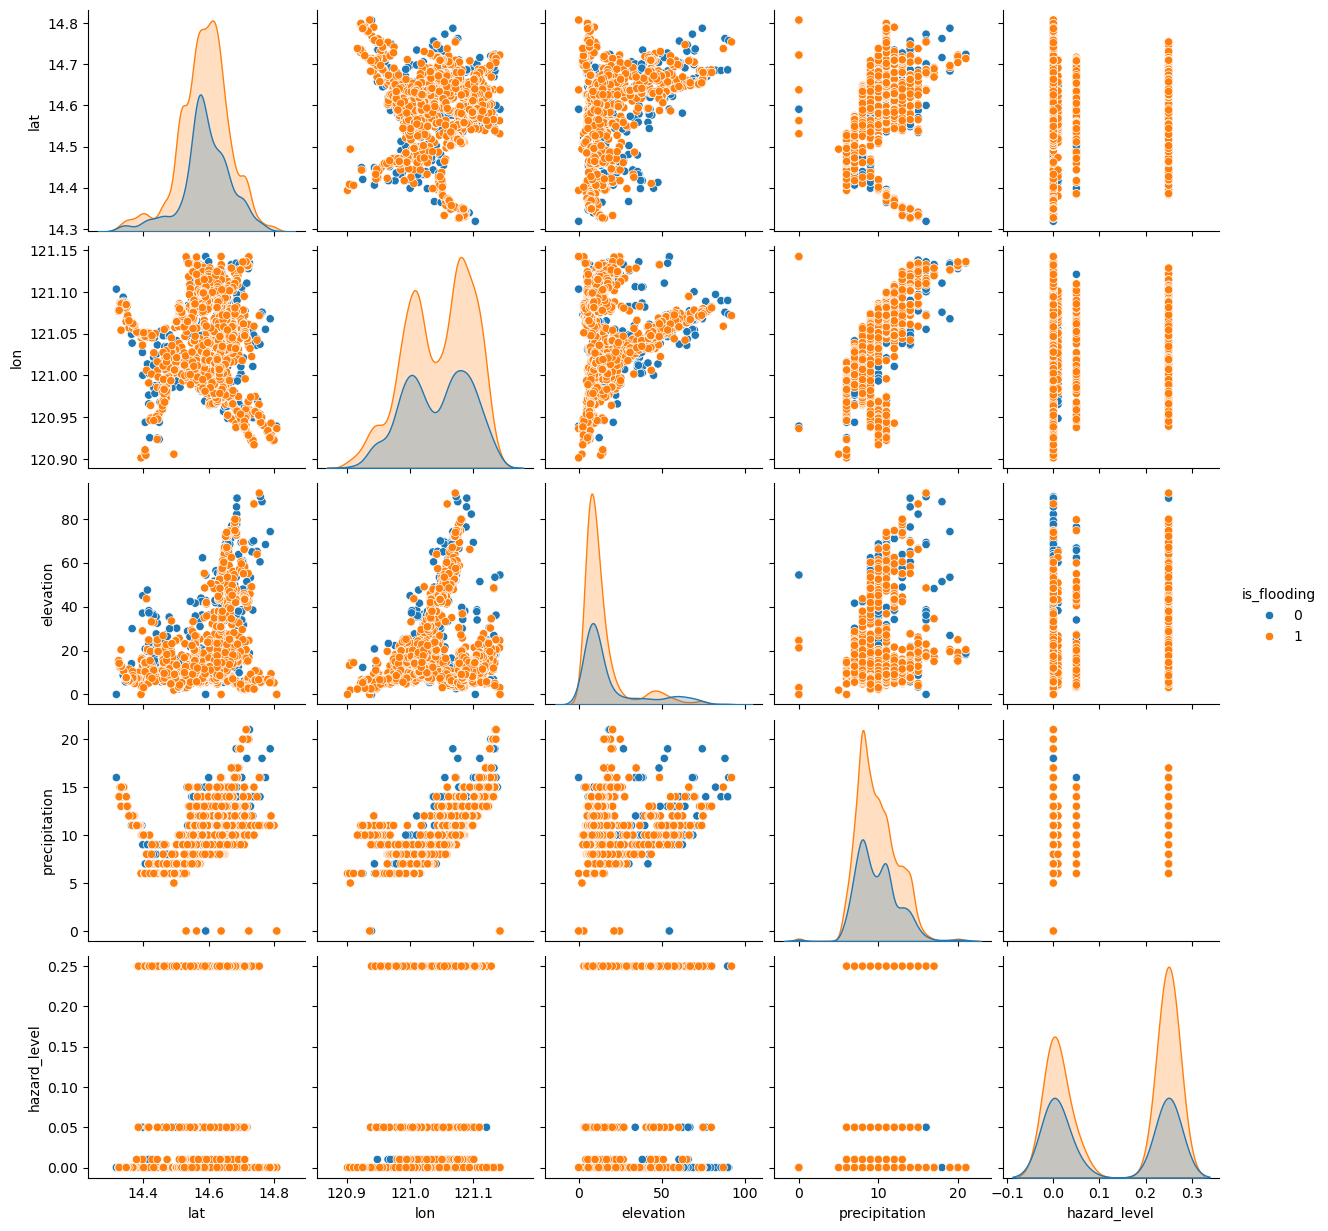

In [9]:
fig = sns.pairplot(df, hue='is_flooding')
fig.figure.savefig('../plots/spairplot.png')

### Euclidian Space
Let's assume that our data can be mapped to euclidian space

In [10]:
reducer = umap.UMAP(random_state=42).fit(df)

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [15]:
joblib.dump(reducer, '../models/euclidian-umap-reducer.joblib')

['../models/euclidian-umap-reducer.joblib']

In [16]:
x = np.sin(reducer.embedding_[:, 0]) * np.cos(reducer.embedding_[:, 1])
y = np.sin(reducer.embedding_[:, 0]) * np.sin(reducer.embedding_[:, 1])
z = np.cos(reducer.embedding_[:, 0])

In [17]:
euclidian_embeddings = reducer.transform(df)
euclidian_embeddings.shape

(3511, 2)

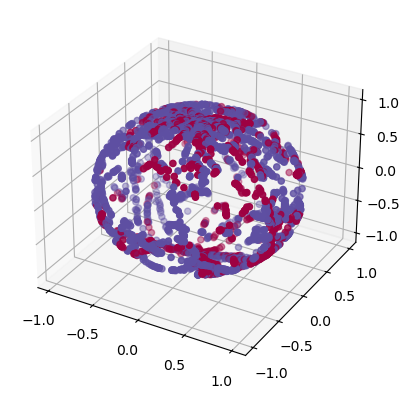

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=df['is_flooding'], cmap='Spectral')

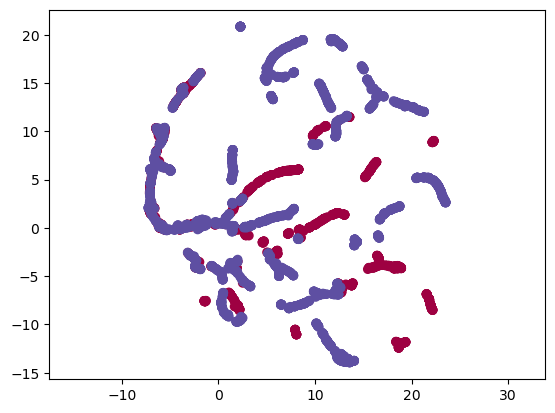

In [22]:
plt.scatter(
    euclidian_embeddings[:, 0],
    euclidian_embeddings[:, 1],
    c=df.is_flooding, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.savefig('../plots/umap-euclidian-manifold-output.png')

In [27]:
euclidian_umap_df = pd.DataFrame(euclidian_embeddings, columns=['umap1', 'umap2'])
euclidian_umap_df['is_flooding'] = df['is_flooding']

### Non-Euclidian Space
Let's assume that our data is non-euclidian

In [16]:
df_for_umap = df.copy()
df_for_umap['lat'] = np.radians(df['lat'])
df_for_umap['lon'] = np.radians(df['lon'])

In [17]:
sphere_mapper = umap.UMAP(output_metric='haversine', random_state=42).fit(df_for_umap)

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [18]:
x = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
y = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
z = np.cos(sphere_mapper.embedding_[:, 0])

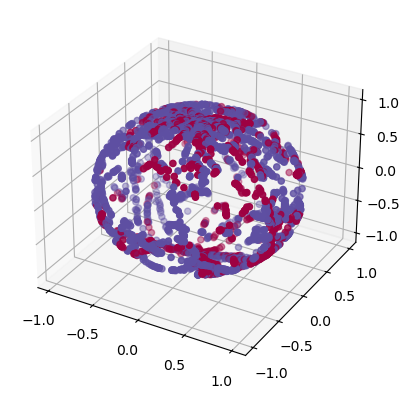

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=df['is_flooding'], cmap='Spectral')
fig.savefig('../plots/haversine-umap-output.png')

Project to 2d dim.

In [35]:
x = np.arctan2(x, y)
y = -np.arccos(z)

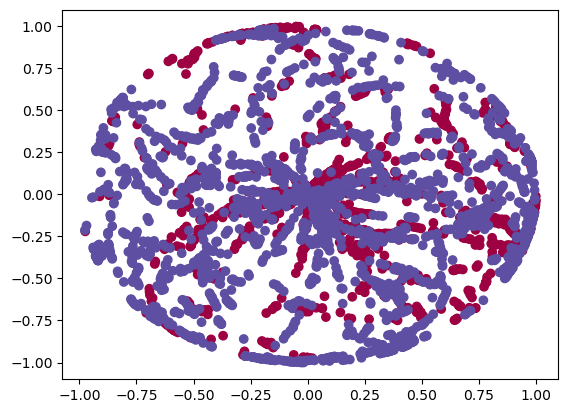

In [25]:
plt.scatter(x, y, c=df['is_flooding'], cmap='Spectral')
plt.savefig('../plots/haversine-umap-scatter-output.png')

In [20]:
non_euclidian_embeddings = sphere_mapper.transform(df_for_umap)
non_euclidian_embeddings.shape

(3511, 2)

In [78]:
data = pd.DataFrame(non_euclidian_embeddings, columns=['umap1', 'umap2'])
data['is_flooding'] = df['is_flooding']

### Non-Euclidian + Scaled Features
As we've seen before, performance with euclidian umap is better than mapping our variables into non-euclidian space. 
Now, let's try to integrate them both together and see its performance.

In [73]:
columns = ["elevation", "precipitation", "hazard_level"]

In [74]:
features = df[columns].values
scaled_features = StandardScaler().fit_transform(features)

In [75]:
scaled_features = pd.DataFrame(scaled_features, columns=columns)

In [76]:
data = df.copy()
data[columns] = scaled_features[columns]

In [54]:
data['lat'] = np.radians(data['lat'])
data['lon'] = np.radians(data['lon'])

In [77]:
data.head()

,lat,lon,elevation,precipitation,is_flooding,hazard_level
0,14.640394,121.055708,2.395394,-0.322990,0,-1.126808
1,14.698299,121.002132,0.367399,0.073243,0,-1.126808
2,14.698858,121.100261,3.311455,2.450637,0,-1.126808
3,14.571310,120.983334,-0.306739,-0.719222,0,-1.126808
4,14.762232,121.075735,4.463054,3.243102,0,-1.126808


In [78]:
umap_model = umap.UMAP(output_metric='haversine').fit(data)

In [79]:
x = np.sin(umap_model.embedding_[:, 0]) * np.cos(umap_model.embedding_[:, 1])
y = np.sin(umap_model.embedding_[:, 0]) * np.sin(umap_model.embedding_[:, 1])
z = np.cos(umap_model.embedding_[:, 0])

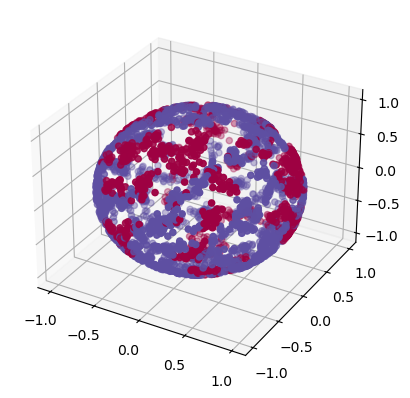

In [80]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=df['is_flooding'], cmap='Spectral')

Project to 2d space.

In [81]:
x = np.arctan2(x, y)
y = -np.arccos(z)

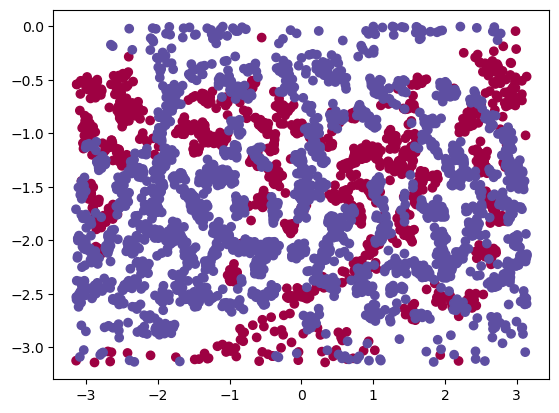

In [82]:
plt.scatter(x, y, c=df['is_flooding'], cmap='Spectral')

In [83]:
geospatial_embeddings = umap_model.transform(data)
geospatial_embeddings.shape

(3511, 2)

In [84]:
geospatial_umap_df = pd.DataFrame(geospatial_embeddings, columns=['umap1', 'umap2'])
geospatial_umap_df['is_flooding'] = df['is_flooding']
geospatial_umap_df.head()

,umap1,umap2,is_flooding
0,-101.163353,18.640230,0
1,-49.925018,162.020905,0
2,-54.015759,-31.732010,0
3,-68.652382,-14.661708,0
4,27.535192,24.845671,0


# Simulate Spatial Random Forest Regression Model (sklearn)

In [29]:
def train_model(x, y):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(x, y)
    return model

def get_data(dataframe, predictor_columns, target_column):
    X = dataframe[predictor_columns].values
    y = dataframe[target_column].values
    return train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

### Using Geospatial UMAP

In [85]:
dataframe = geospatial_umap_df.copy()
target_column = 'is_flooding'
predictor_columns = [col for col in dataframe.columns if col not in target_column]

rf_model = train_model(dataframe, predictor_columns, target_column)

rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_confusion = confusion_matrix(y_test, rf_predictions)
print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Random Forest Confusion Matrix:\n", rf_confusion)

Random Forest Classifier Accuracy: 0.604551920341394
Random Forest Confusion Matrix:
 [[ 65 204]
 [ 74 360]]


### Using Euclidian UMAP

In [30]:
dataframe = euclidian_umap_df.copy()
target_column = 'is_flooding'
predictor_columns = [col for col in dataframe.columns if col not in target_column]
x_train, x_test, y_train, y_test = get_data(dataframe, predictor_columns, target_column)
rf_model = train_model(x_train, y_train)
rf_predictions = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_confusion = confusion_matrix(y_test, rf_predictions)
rmse_spatial_rf = root_mean_squared_error(rf_predictions, y_test)
print("RMSE Error of spatial Random Forest: ", rmse_spatial_rf)
print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Random Forest F1-Score:", f1_score(y_test, rf_predictions))
print("Random Forest Confusion Matrix:\n", rf_confusion)

RMSE Error of spatial Random Forest:  0.296973831531516
Random Forest Classifier Accuracy: 0.9118065433854907
Random Forest F1-Score: 0.9304932735426009
Random Forest Confusion Matrix:
 [[226  43]
 [ 19 415]]


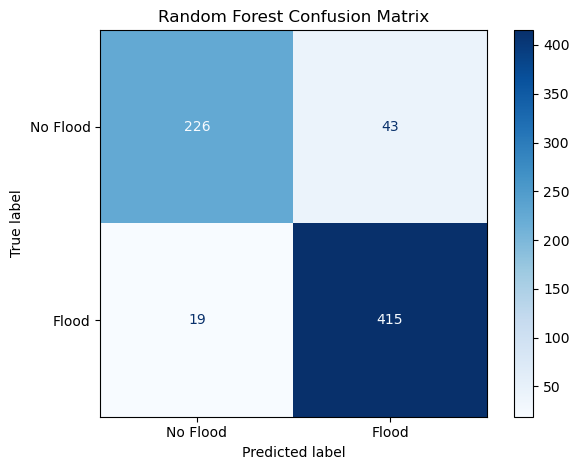

In [90]:
ConfusionMatrixDisplay(rf_confusion, display_labels=['No Flood', 'Flood']).plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

### K-fold Validation

In [98]:
dataframe = euclidian_umap_df.copy()
target_column = 'is_flooding'
predictor_columns = [col for col in dataframe.columns if col not in target_column]
X = dataframe[predictor_columns]
y = dataframe[target_column]

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store the MSE values for each fold
folds = []
rmse_values = []

# Perform the K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training set
    model = train_model(x_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(x_test)
    
    # Calculate the mean squared error
    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_values.append(rmse)
    folds.append(f'Fold {len(folds) + 1}')

# Output the mean MSE over the folds
print(f"Mean RMSE: {np.mean(rmse_values)}")

Mean RMSE: 0.2521370258863135


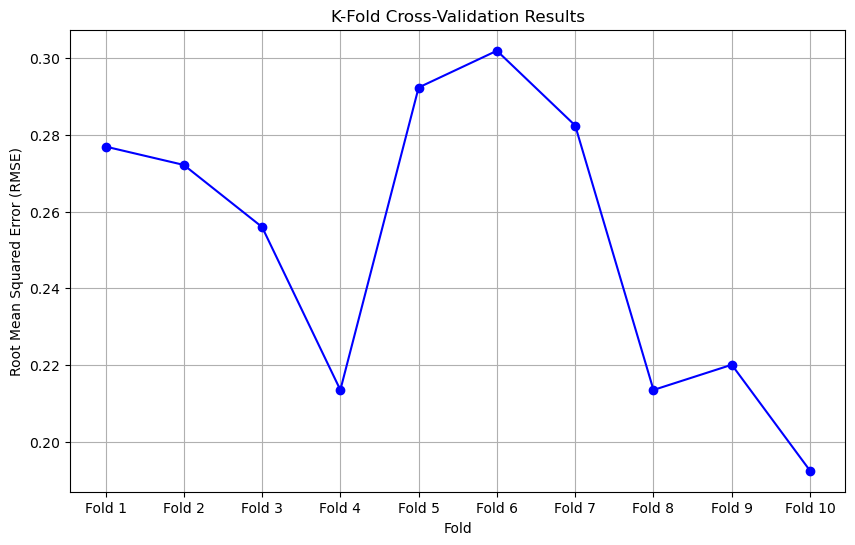

In [99]:
# Plotting the MSE for each fold
plt.figure(figsize=(10, 6))
plt.plot(folds, rmse_values, marker='o', linestyle='-', color='b', label='MSE per Fold')

# Add labels and title
plt.title('K-Fold Cross-Validation Results')
plt.xlabel('Fold')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.show()

In [129]:
# Calculate and print the average and standard deviation of MSE
mean_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

print(f"Average RMSE: {mean_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")

Average RMSE: 0.2521
Standard Deviation of RMSE: 0.0369


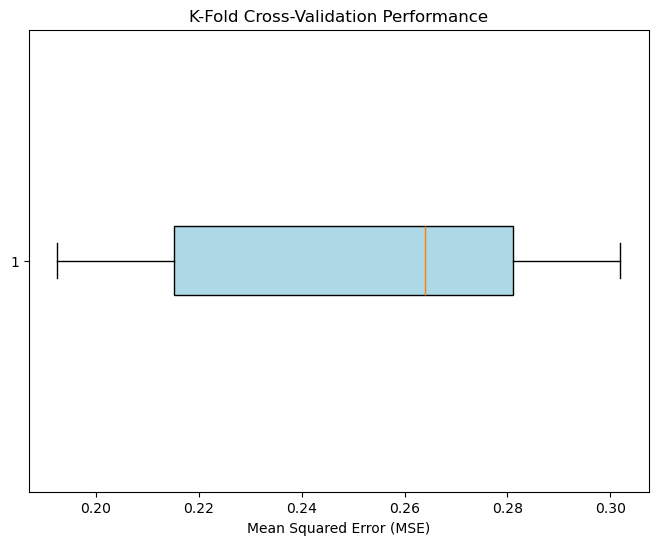

In [101]:
plt.figure(figsize=(8, 6))
plt.boxplot(rmse_values, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('K-Fold Cross-Validation Performance')
plt.xlabel('Mean Squared Error (MSE)')
plt.show()

In [ ]:
thresholds = np.arange(0, 1, 0.01)
scores = []  # TODO: Should we use f1-scores?

for threshold in thresholds:
    binary_predictions = (test_pred >= threshold).astype(int)
    score = roc_auc_score(test_y, binary_predictions)
    scores.append(score)

# Find the threshold that gives the highest F1 score
optimal_threshold = thresholds[np.argmax(scores)]
print("Optimal Threshold for roc-auc-score:", optimal_threshold)

### Compare With Other Models

In [103]:
dataframe = df.copy()
target_column = 'is_flooding'
predictor_columns = [col for col in dataframe.columns if col not in [target_column]]

# Step 2: Train-Test Split
x_train, x_test, y_train, y_test = get_data(dataframe, predictor_columns, target_column)

# Logistic Regression as an additional baseline model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(x_train, y_train)

# Logistic Regression Predictions and Evaluation
lr_predictions = lr_model.predict(x_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_confusion = confusion_matrix(y_test, lr_predictions)
print("Logistic Regression Accuracy:", lr_accuracy)
print("Logistic Regression Confusion Matrix:\n", lr_confusion)

Logistic Regression Accuracy: 0.6486486486486487
Logistic Regression Confusion Matrix:
 [[ 29 240]
 [  7 427]]


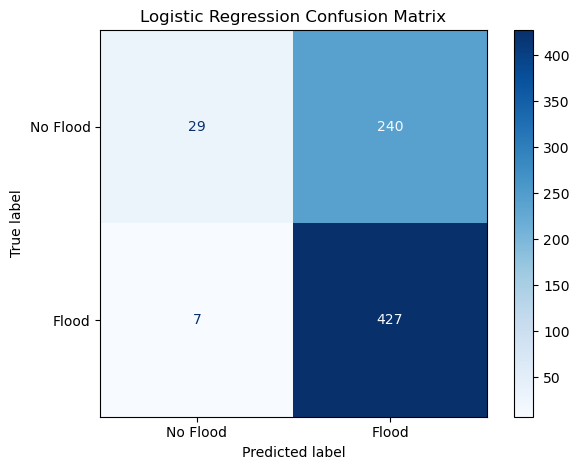

In [104]:
ConfusionMatrixDisplay(lr_confusion, display_labels=['No Flood', 'Flood']).plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()

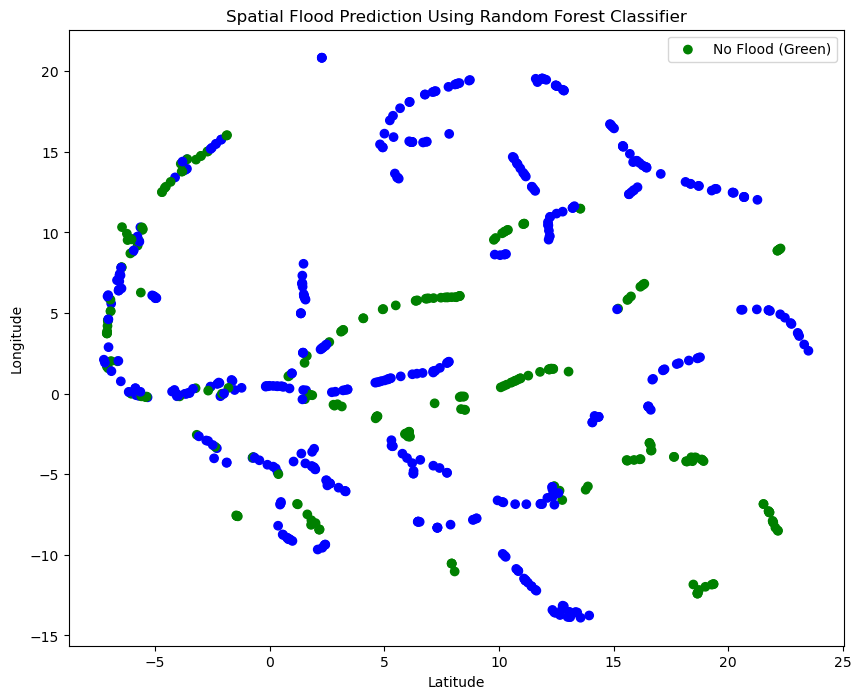

In [130]:
# Step 5: Visualize Spatial Predictions from Random Forest Model
# Assuming latitude and longitude are the first two columns in X_test
plt.figure(figsize=(10, 8))
colors = np.where(rf_predictions == 1, 'blue', 'green')
plt.scatter(x_test[:, 0], x_test[:, 1], c=colors, marker='o', label='Predicted Flood')
# plt.colorbar(label='Flood Prediction')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Spatial Flood Prediction Using Random Forest Classifier')
plt.legend(['No Flood (Green)'])
plt.show()

### Random Forest Optimization Using Parzen Tree (Optuna)

In [105]:
# Specify columns
dataframe = euclidian_umap_df.copy()
target_column = 'is_flooding'
predictor_columns = [col for col in dataframe.columns if col not in target_column]

# Train-Test Split
x_train, x_test, y_train, y_test = get_data(dataframe, predictor_columns, target_column)

In [106]:
def objective(trial):
    # Define the hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Initialize the model with these hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Train the model and evaluate it on the validation set
    model = model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    rmse = root_mean_squared_error(y_test, predictions)
    return rmse

# Step 2: Set up Optuna study with TPE sampler
# sampler = optuna.samplers.TPESampler(seed=42)
# study = optuna.create_study(direction="maximize", sampler=sampler)
study = optuna.create_study(direction="minimize")

# Step 3: Run the optimization with a specified number of trials
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best Hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2024-11-12 04:59:03,802] A new study created in memory with name: no-name-38887190-8bfc-478d-af66-5fd6dac190bc
[I 2024-11-12 04:59:05,170] Trial 0 finished with value: 0.3040738100109349 and parameters: {'n_estimators': 259, 'max_depth': 41, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.3040738100109349.
[I 2024-11-12 04:59:05,681] Trial 1 finished with value: 0.3017257145618857 and parameters: {'n_estimators': 108, 'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 1 with value: 0.3017257145618857.
[I 2024-11-12 04:59:06,192] Trial 2 finished with value: 0.2847473987257497 and parameters: {'n_estimators': 94, 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 2 with value: 0.2847473987257497.
[I 2024-11-12 04:59:06,848] Trial 3 finished with value: 0.34567023152362014 and parameters: {'n_estimators': 176, 'max_depth': 8, 'm

Best Hyperparameters: {'n_estimators': 82, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None}
Best RMSE: 0.27197188374472264


In [107]:
# refit model
# Use the best hyperparameters to train the final model
best_params = study.best_params
best_model = RandomForestClassifier(**best_params)
best_model.fit(x_train, y_train)

# Evaluate on the test set
predictions = best_model.predict(x_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'Optimized RMSE: {rmse:.2f} minutes')

Optimized RMSE: 0.28 minutes


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [108]:
rf_accuracy = accuracy_score(y_test, predictions)
rf_confusion = confusion_matrix(y_test, predictions)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Confusion Matrix:\n", rf_confusion)

Random Forest Accuracy: 0.918918918918919
Random Forest Confusion Matrix:
 [[226  43]
 [ 14 420]]


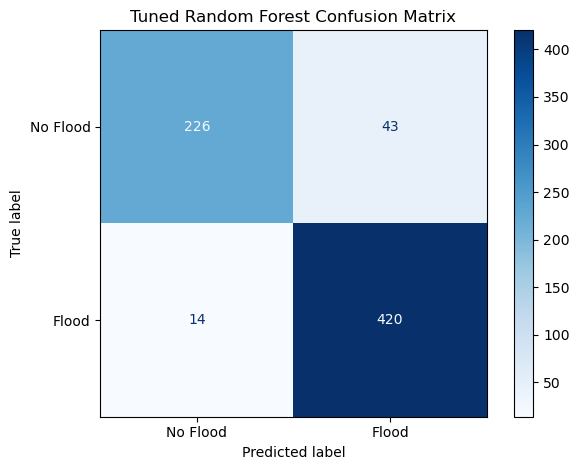

In [109]:
ConfusionMatrixDisplay(rf_confusion, display_labels=['No Flood', 'Flood']).plot(cmap='Blues')
plt.title("Tuned Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

In [111]:
# Print feature importances
importances = rf_model.feature_importances_
print("Feature importances of UMAP embeddings:")
for i, imp in enumerate(importances):
    print(f"UMAP Feature {i+1}: {imp:.4f}")

Feature importances of UMAP embeddings:
UMAP Feature 1: 0.4508
UMAP Feature 2: 0.5492


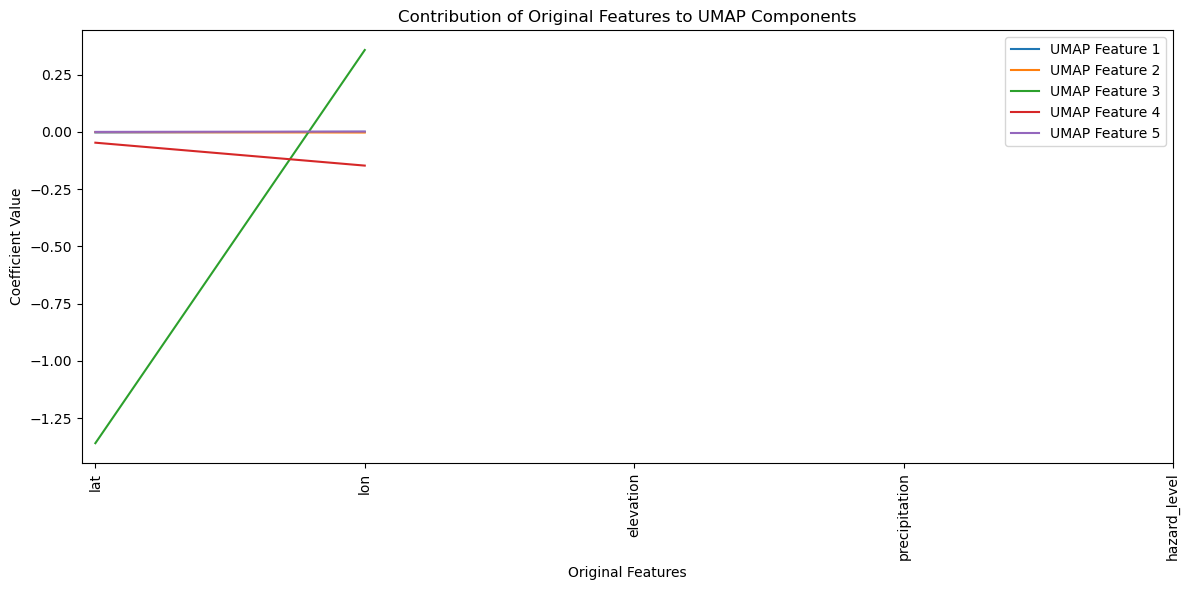

In [128]:
# Fit a Linear Regression model to map UMAP components back to the original features
linear_model = LinearRegression()
x_umap = dataframe[predictor_columns]
x = df[[column for column in df.columns if not column in target_column]]
linear_model.fit(x_umap, x)  # Map UMAP components to original features

# Get the coefficients (weights) of the original features for each UMAP component
coefficients = linear_model.coef_

# Plot the coefficients for each original feature in each UMAP component
plt.figure(figsize=(12, 6))

# Create a plot for each UMAP component's feature contributions
for i in range(coefficients.shape[0]):
    plt.plot(range(len(coefficients[i])), coefficients[i], label=f'UMAP Feature {i+1}')

# Set labels with the original feature names
plt.xticks(range(len(x.columns)), x.columns, rotation=90)

# Add labels and title
plt.xlabel('Original Features')
plt.ylabel('Coefficient Value')
plt.title('Contribution of Original Features to UMAP Components')
plt.legend()
plt.tight_layout()  # To prevent overlapping of labels
plt.show()

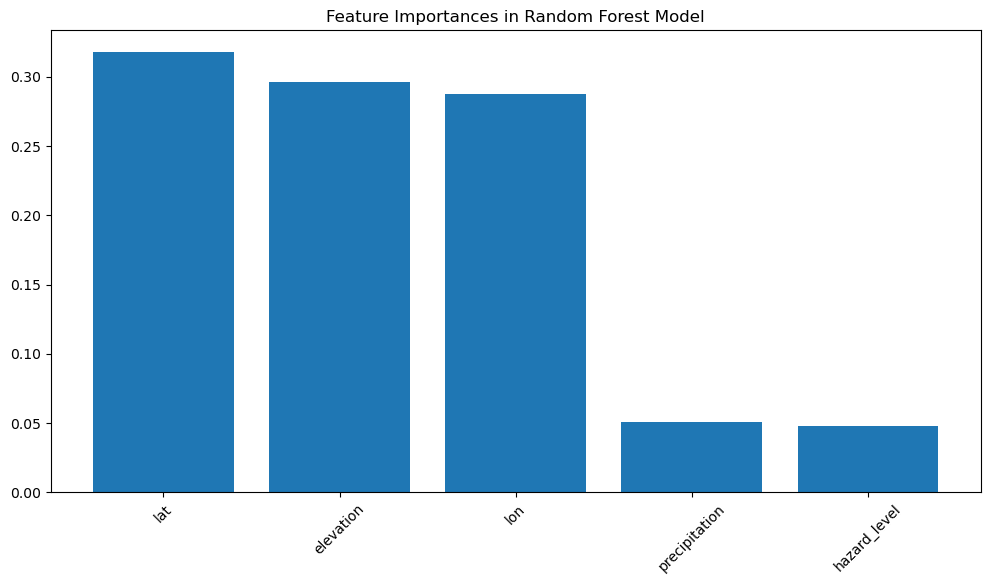

In [37]:
# Visualization of Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_indices], rotation=45)
plt.title("Feature Importances in Random Forest Model")
plt.show()

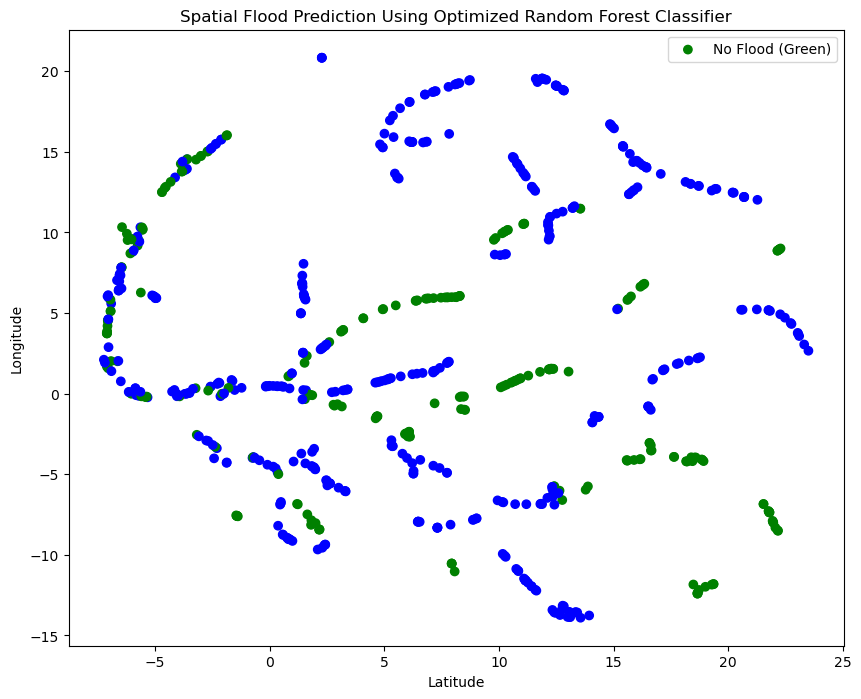

In [110]:
# Visualization of Predictions in UMAP Space
colors = np.where(rf_predictions == 1, 'blue', 'green')
plt.figure(figsize=(10, 8))
plt.scatter(x_test[:, 0], x_test[:, 1], c=colors, marker='o', label='Predicted Flood')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Spatial Flood Prediction Using Optimized Random Forest Classifier')
plt.legend(['No Flood (Green)'])
plt.show()

## Sprf module

### Load Data

In [39]:
# Define target variable and coordinates for the AEGIS dataset
target = 'is_flooding'  # Update if using a different target column
lon = 'lon'             # Replace with the actual longitude column name in your dataset
lat = 'lat'             # Replace with the actual latitude column name in your dataset

### Split into Train and Test

In [37]:
data['lon'] = df['lat']
data['lat'] = df['lon']

In [60]:
data = df

In [48]:
data.head()

,umap1,umap2,is_flooding,lon,lat
0,23.818695,-84.597412,0,14.640394,121.055708
1,18.374092,37.800732,0,14.698299,121.002132
2,-57.763351,35.701462,0,14.698858,121.100261
3,-20.460720,36.693226,0,14.571310,120.983334
4,-25.840223,-19.953157,0,14.762232,121.075735


In [61]:
# Splitting into train and test sets
def prepare_data(data, target, lon=lon, lat=lat):
    """Assumes all columns except lon, lat, and target are covariates."""
    covariates = [col for col in data.columns if col not in [lon, lat, target]]
    return data[covariates], data[target], data[[lon, lat]]

In [62]:
# Random split
inds = np.random.permutation(len(data))
split = int(0.9 * len(data))
train_data = data.iloc[inds[:split]]
test_data = data.iloc[inds[split:]]

# Prepare train and test sets
train_x, train_y, train_coords = prepare_data(train_data, target)
test_x, test_y, test_coords = prepare_data(test_data, target)

In [63]:
# Lists to track accuracy
train_accuracies = []
test_accuracies = []

In [64]:
# Ensure data is binary
print("Unique values in train_y:", np.unique(train_y))
print("Unique values in test_y:", np.unique(test_y))

Unique values in train_y: [0 1]
Unique values in test_y: [0 1]


### Train and Test Spatial Random Forest

In [65]:
n_estimators = 100
max_depth = 10
spatial_neighbors = len(data) // 5  # Adjust as needed

In [66]:
# Train and test Spatial Random Forest
sp = SpatialRandomForest(max_depth=max_depth, neighbors=spatial_neighbors)
sp.fit(train_x, train_y, train_coords)
test_pred = sp.predict(test_x, test_coords)

rmse_spatial_rf = root_mean_squared_error(test_pred, test_y)
print("RMSE Error of spatial Random Forest: ", rmse_spatial_rf)

RMSE Error of spatial Random Forest:  0.45889898253319167


In [67]:
thresholds = np.arange(0, 1, 0.01)
scores = []  # TODO: Should we use f1-scores?

for threshold in thresholds:
    binary_predictions = (test_pred >= threshold).astype(int)
    score = roc_auc_score(test_y, binary_predictions)
    scores.append(score)

# Find the threshold that gives the highest F1 score
optimal_threshold = thresholds[np.argmax(scores)]
print("Optimal Threshold for roc-auc-score:", optimal_threshold)

Optimal Threshold for roc-auc-score: 0.67


In [68]:
# Random Forest Predictions and Evaluation
predictions = (test_pred >= optimal_threshold).astype(int)
rf_accuracy = accuracy_score(test_y, predictions)
rf_confusion = confusion_matrix(test_y, predictions)
print("Spatial Random Forest F1 Score:", f1_score(test_y, predictions))
print("Spatial Random Forest Classifier Accuracy:", rf_accuracy)
print("Spatial Random Forest Confusion Matrix:\n", rf_confusion)

Spatial Random Forest F1 Score: 0.6762589928057554
Spatial Random Forest Classifier Accuracy: 0.6164772727272727
Spatial Random Forest Confusion Matrix:
 [[ 76  43]
 [ 92 141]]


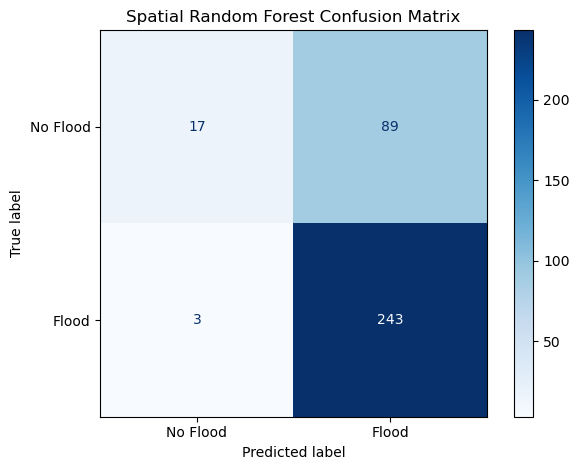

In [17]:
ConfusionMatrixDisplay(rf_confusion, display_labels=['No Flood', 'Flood']).plot(cmap='Blues')
plt.title("Spatial Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

### Train and test geographical random forest

In [18]:
# Train and test Geographical Random Forest
geo_rf = GeographicalRandomForest(n_estimators=n_estimators, neighbors=spatial_neighbors, max_depth=max_depth)
geo_rf.fit(train_x, train_y, train_coords)
test_pred = geo_rf.predict(test_x, test_coords)

rmse_spatial_rf = root_mean_squared_error(test_pred, test_y)
print("RMSE Error of spatial Random Forest: ", rmse_spatial_rf)

In [19]:
thresholds = np.arange(0, 1, 0.01)
f1_scores = []

for threshold in thresholds:
    binary_predictions = (test_pred >= threshold).astype(int)
    f1 = f1_score(test_y, binary_predictions)
    f1_scores.append(f1)

# Find the threshold that gives the highest F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold for F1-score:", optimal_threshold)

Optimal Threshold for F1-score: 0.19


In [25]:
# Random Forest Predictions and Evaluation
predictions = (test_pred >= optimal_threshold).astype(int)
rf_accuracy = accuracy_score(test_y, predictions)
rf_confusion = confusion_matrix(test_y, predictions)
print("Geographical RF F1 Score:", f1_score(test_y, predictions))
print("Geographical RF Classifier Accuracy:", rf_accuracy)
print("Geographical RF Confusion Matrix:\n", rf_confusion)

RMSE Error of Geographical Random Forest:  0.5222329678670935
Geographical RF F1 Score: 0.8356164383561644
Geographical RF Classifier Accuracy: 0.7272727272727273
Geographical RF Confusion Matrix:
 [[ 12  94]
 [  2 244]]


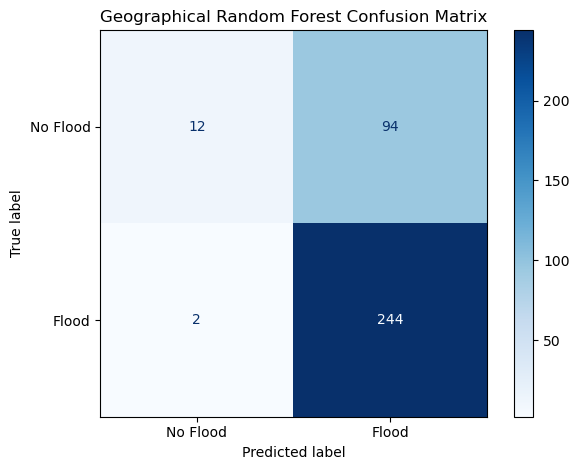

In [28]:
ConfusionMatrixDisplay(rf_confusion, display_labels=['No Flood', 'Flood']).plot(cmap='Blues')
plt.title("Geographical Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

# Conclusion